## Trial by trial decoding analysis

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import spyglass as nd
import pandas as pd
import os
# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import logging
import multiprocessing

FORMAT = '%(asctime)s %(message)s'

logging.basicConfig(level='INFO', format=FORMAT, datefmt='%d-%b-%y %H:%M:%S')

from spyglass.common import (Session, IntervalList,IntervalPositionInfo,
                             LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common.common_interval import _intersection

import spyglass.spikesorting as ss
from spyglass.spikesorting import (SortGroup, 
                                    SortInterval,
                                    SpikeSortingPreprocessingParameters,
                                    SpikeSortingRecording, 
                                    SpikeSorterParameters,
                                    SpikeSortingRecordingSelection,
                                    ArtifactDetectionParameters, ArtifactDetectionSelection,
                                    ArtifactRemovedIntervalList, ArtifactDetection,
                                      SpikeSortingSelection, SpikeSorting,
                                   CuratedSpikeSortingSelection,CuratedSpikeSorting,Curation)
#from spyglass.decoding.clusterless import (UnitMarks,
#                                           UnitMarkParameters,UnitMarksIndicatorSelection,
#                                          UnitMarksIndicator)
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from spyglass.common.common_position import IntervalPositionInfo, IntervalPositionInfoSelection
from spyglass.common.common_position import IntervalLinearizedPosition


# Here are the analysis tables specific to Shijie Gu
from spyglass.shijiegu.Analysis_SGU import (TrialChoice,
                                   TrialChoiceReplay,
                                   RippleTimes,
                                   Decode,get_linearization_map,
                                   find_ripple_times,mua_thresholder,
                                   segment_ripples,sort_replays,
                                   classify_ripples,classify_ripple_content,
                                   load_everything,plot_decode_spiking,
                                  )

[2023-06-20 22:29:49,106][INFO]: Connecting shijiegu@lmf-db.cin.ucsf.edu:3306
20-Jun-23 22:29:49 Connecting shijiegu@lmf-db.cin.ucsf.edu:3306
[2023-06-20 22:29:49,162][INFO]: Connected shijiegu@lmf-db.cin.ucsf.edu:3306
20-Jun-23 22:29:49 Connected shijiegu@lmf-db.cin.ucsf.edu:3306
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/position_tools/core.py:3: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d
20-Jun-23 22:29:50 Populate: Entry in DataAcquisitionDeviceSystem with primary keys {'data_acquisition_device_system': 'SpikeGadgets'} already exists.
20-Jun-23 22:29:50 Populate: Entry in DataAcquisitionDeviceAmplifier with primary keys {'data_acquisition_device_amplifier': 'Intan'} already exists.


In [3]:
# the only cell to be edited
nwb_file_name = 'eliot20221024.nwb'
#epoch_num=4

In [4]:
TrialChoice()

*nwb_file_name *epoch    epoch_name     choice_rew
+------------+ +-------+ +------------+ +--------+
eliot20221016_ 2         02_Seq2Session =BLOB=    
eliot20221016_ 4         04_Seq2Session =BLOB=    
eliot20221016_ 6         06_Seq2Session =BLOB=    
eliot20221016_ 8         08_Seq2Session =BLOB=    
eliot20221017_ 2         02_Seq2Session =BLOB=    
eliot20221017_ 4         04_Seq2Session =BLOB=    
eliot20221017_ 6         06_Seq2Session =BLOB=    
eliot20221017_ 8         08_Seq2Session =BLOB=    
eliot20221018_ 2         02_Seq2Session =BLOB=    
eliot20221018_ 4         04_Seq2Session =BLOB=    
eliot20221018_ 5         05_Seq2Session =BLOB=    
eliot20221018_ 7         07_Seq2Session =BLOB=    
   ...
 (Total: 83)

In [5]:
nwb_copy_file_name = get_nwb_copy_filename(nwb_file_name)
TrialChoice() & {'nwb_file_name':nwb_copy_file_name}

*nwb_file_name *epoch    epoch_name     choice_rew
+------------+ +-------+ +------------+ +--------+
eliot20221024_ 2         02_Seq2Session =BLOB=    
eliot20221024_ 4         04_Seq2Session =BLOB=    
eliot20221024_ 6         06_Seq2Session =BLOB=    
eliot20221024_ 8         08_Seq2Session =BLOB=    
eliot20221024_ 10        10_Seq2Session =BLOB=    
 (Total: 5)

In [6]:
def interpolate_to_new_time(df, new_time, upsampling_interpolation_method='linear'):
    old_time = df.index
    new_index = pd.Index(np.unique(np.concatenate(
        (old_time, new_time))), name='time')
    return (df
            .reindex(index=new_index)
            .interpolate(method=upsampling_interpolation_method)
            .reindex(index=new_time))

In [14]:
def find_ripple_classify_decode(log_df,
                                node_location,linear_position_df,
                                ripple_times,decode,recordings,neural_ts, #spiking data
                                ripple_nwb,ripple_timestamps,
                                mua,mua_time,mua_threshold,
                                exampledir,
                                t):

    # for each trial, find important times
    t_home=log_df.loc[t,'timestamp_H']
    t_outer=log_df.loc[t,'timestamp_O']
    if t+1<len(log_df):
        t_end=log_df.loc[t+1,'timestamp_H']
    else:
        t_end=log_df.loc[t,'timestamp_H']+10
    
    ''' HOME '''
    # find times close to home well
    time_slice = slice(t_home,t_outer)
    current_location = node_location['home']
    position_subset=linear_position_df.loc[time_slice]
    close_ind=np.argwhere(np.abs(position_subset.linear_position.values-
                                 current_location)<5).ravel()
    try:
        t_home_start=position_subset.index[close_ind[0]]
        t_home_end=position_subset.index[close_ind[-1]]
    except:
        print('trial failed:',t)
        print('position_subset',position_subset)
        return [],[],[],[],[],[]
    
    # Home well ripple
    ripple_H_=find_ripple_times(ripple_times,t_home_start,t_home_end)
    
    # remove those replays without mua above the mean
    print(mua_threshold)
    ripple_H_=mua_thresholder(ripple_H_,mua,mua_time,mua_threshold)
    
    # segment ripple
    # unsegmented is "ripple_H_", segmented is called "cont_ripple_H" or "frag_ripple_H"
    cont_ripple_H,frag_ripple_H=segment_ripples(decode,ripple_H_)
    
    # classify into arms, Home well replay, only for continuous replays
    cont_replay_H=classify_ripples(decode,cont_ripple_H)
    
    assert len(cont_ripple_H)==len(cont_replay_H)
    
    # sort
    ripple_H,replay_H=sort_replays(cont_ripple_H,frag_ripple_H,cont_replay_H)
    
    '''plot each ripple at home, meanwhile find peak'''
    peak_H=[]
    
    for i in range(np.shape(ripple_H_)[0]):
        peaks=plot_decode_spiking(ripple_H_[i],    #ripple start and end time
                            linear_position_df,
                            decode, #decode result
                            recordings,neural_ts, #spiking data
                            ripple_nwb,ripple_timestamps,#ripple
                            offset=1, #2 second window
                            savefolder=exampledir,
                            title='classified as: arm '+str(replay_H[i]),
                            savename='trial'+str(t)+'_home_'+str(i+1))
        peak_H.append(peaks)
    
    
    ''' OUTER '''
    # find times close to outer
    time_slice = slice(t_home,t_end)
    current_location = node_location['well'+str(int(log_df.loc[t,'OuterWellIndex']))]
    position_subset=linear_position_df.loc[time_slice]
    close_ind=np.argwhere(np.abs(position_subset.linear_position.values-
                                 current_location)<5).ravel()
    try:
        t_outer_start=position_subset.index[close_ind[0]]
        t_outer_end=position_subset.index[close_ind[-1]]
    except:
        print('trial failed:',t)
        print('position_subset',position_subset)
        return [],[],[],[],[],[]
    
    
    # Outer well replay
    ripple_O_=find_ripple_times(ripple_times,t_outer_start,t_outer_end)
    
    # remove those replays without mua above the mean
    ripple_O_=mua_thresholder(ripple_O_,mua,mua_time,mua_threshold)
    
    # segment ripple
    cont_ripple_O,frag_ripple_O=segment_ripples(decode,ripple_O_)
    
    # classify ripple
    cont_replay_O=classify_ripples(decode,cont_ripple_O)
    
    assert len(cont_ripple_O)==len(cont_replay_O)
    
    # sort
    ripple_O,replay_O=sort_replays(cont_ripple_O,frag_ripple_O,cont_replay_O)
    
    '''plot each ripple at outer well'''
    peak_O=[]
    for i in range(np.shape(ripple_O_)[0]):
        peaks=plot_decode_spiking(ripple_O_[i],    #ripple start and end time
                            linear_position_df,
                            decode, #decode result
                            recordings,neural_ts, #spiking data
                            ripple_nwb,ripple_timestamps,#ripple
                            offset=1, #2 second window
                            savefolder=exampledir,
                            title='classified as: arm '+str(replay_O[i]),
                            savename='trial'+str(t)+'_outer_'+str(i+1))
        peak_O.append(peaks)
        
    return ripple_H,replay_H,peak_H,ripple_O,replay_O,peak_O

In [15]:
def add_replay(epoch_num):
    # RUN THIS CELL AFTER CHANGING FILE
    
    # 1. Load state script
    key={'nwb_file_name':nwb_copy_file_name,'epoch':epoch_num}
    log=(TrialChoice & key).fetch1('choice_reward')
    epoch_name=(TrialChoice & key).fetch1('epoch_name')
    epoch_pos_name='pos '+str(int(epoch_name[:2])-1)+' valid times'
    print('epoch name',epoch_name)
    log_df=pd.DataFrame(log)

    # 1.5 Pre-make result directory:
    decoding_path=(Decode() & {'nwb_file_name':nwb_copy_file_name}).fetch('posterior')[0]
    exampledir=os.path.join(os.path.split(decoding_path)[0],nwb_file_name,epoch_name)
    isExist = os.path.exists(exampledir)
    if not isExist:
        os.makedirs(exampledir)

    # 2. Pre-expand result: Augment choice_reward table to be choice_reward_replay
    log_df_replay=log_df.copy()
    log_df_replay.insert(5,'ripple_H',[[] for i in range(len(log_df))]) #hold ripple times
    log_df_replay.insert(6,'ripple_O',[[] for i in range(len(log_df))])
    log_df_replay.insert(7,'replay_H',[[] for i in range(len(log_df))]) #hold decoded replay
    log_df_replay.insert(8,'ripple_peak_H',[[] for i in range(len(log_df))]) #hold decoded replay
    log_df_replay.insert(9,'replay_O',[[] for i in range(len(log_df))])
    log_df_replay.insert(10,'ripple_peak_O',[[] for i in range(len(log_df))]) #hold decoded replay

    # 3. linear map
    linear_map,node_location=get_linearization_map()

    # 4. load position, decoding, ripple times, mua threshold
    (linear_position_df,decode,ripple_nwb,
     ripple_timestamps,ripple_times,
     recordings,neural_ts,
     mua,mua_time)=load_everything(nwb_copy_file_name,
                    epoch_name,
                    epoch_pos_name)

    # 5. find immobility times position
    position_info_param_name = 'default'
    position_valid_times = (IntervalList & {'nwb_file_name': nwb_copy_file_name,
                                            'interval_list_name': epoch_pos_name}).fetch1('valid_times')

    position_info = (IntervalPositionInfo() & {'nwb_file_name': nwb_copy_file_name,
                     'interval_list_name': epoch_pos_name,
                     'position_info_param_name': position_info_param_name}).fetch1_dataframe()

    position_info = pd.concat(
        [position_info.loc[slice(valid_time[0], valid_time[1])]
         for valid_time in position_valid_times], axis=0)

    head_speed=pd.DataFrame(position_info['head_speed'])

    position_info_upsample = interpolate_to_new_time(head_speed, mua_time)

    imobility_ind=position_info_upsample['head_speed']<=5
    mua_threshold=np.mean(mua[imobility_ind])


    # find legal trials
    rewardNum=np.array(log_df.rewardNum)
    legal_trials=(np.argwhere(np.logical_and(rewardNum[1:]>=1,rewardNum[:-1]>=1))+1).ravel()

    trial_ind=np.array(log_df.index)
    
    '''
    here the actual work gets done
    '''
    #numWorker=30
    #print('num of worker:',numWorker)
    #with multiprocessing.Pool(numWorker) as p:
    #    results=p.map(find_ripple_classify_decode,legal_trials)
    for t in legal_trials:
        print('trial',t)
        results=find_ripple_classify_decode(log_df,
                                            node_location,linear_position_df,
                                            ripple_times,decode,recordings,neural_ts, #spiking data
                                            ripple_nwb,ripple_timestamps,
                                            mua,mua_time,mua_threshold,
                                            exampledir,
                                            t)
        

        # add to the choice_reward_replay
        log_df_replay.at[t, 'ripple_H']=results[0]
        log_df_replay.at[t, 'ripple_O']=results[3]
    
        log_df_replay.at[t, 'replay_H']= results[1]
        log_df_replay.at[t, 'replay_O']= results[4]
    
        #log_df_replay.at[t, 'ripple_peak_H']= results[2]
        #log_df_replay.at[t, 'ripple_peak_O']= results[5]
    print('Done parsing. Insert into Spyglass')
    log_df_replay_subset=log_df_replay.loc[legal_trials,:].copy()
    
    # insert into Spyglass
    key={'nwb_file_name':nwb_copy_file_name,'epoch':epoch_num,'choice_reward_replay':log_df_replay_subset.to_dict()}
    TrialChoiceReplay().make(key,replace=True)

In [ ]:
%%capture stored_output
add_replay(2)
add_replay(4)
add_replay(6)
add_replay(8)

### for whole day

In [16]:
all_epochs=list((TrialChoice() & {'nwb_file_name':nwb_copy_file_name}).fetch('epoch'))
all_epochs

[2, 4, 6, 8]

In [16]:
%%capture stored_output
with multiprocessing.Pool(3) as p:
    p.map(add_replay,all_epochs)

[2023-06-09 10:36:32,416][WARNING]: MySQL server has gone away. Reconnecting to the server.
[2023-06-09 10:36:32,416][WARNING]: MySQL server has gone away. Reconnecting to the server.
[2023-06-09 10:36:32,416][WARNING]: MySQL server has gone away. Reconnecting to the server.
09-Jun-23 10:36:32 MySQL server has gone away. Reconnecting to the server.
09-Jun-23 10:36:32 MySQL server has gone away. Reconnecting to the server.
09-Jun-23 10:36:32 MySQL server has gone away. Reconnecting to the server.


KeyboardInterrupt: 

epoch name 02_Seq2Session1
trial 1
30.924398121507775
trial 2
30.924398121507775
trial 3
30.924398121507775
trial 4
30.924398121507775
trial 5
30.924398121507775
trial 6
30.924398121507775
trial 9
30.924398121507775
trial 12
30.924398121507775
trial 15
30.924398121507775
trial 18
30.924398121507775
Error in callback <function flush_figures at 0x7f4d8ed974c0> (for post_execute):


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

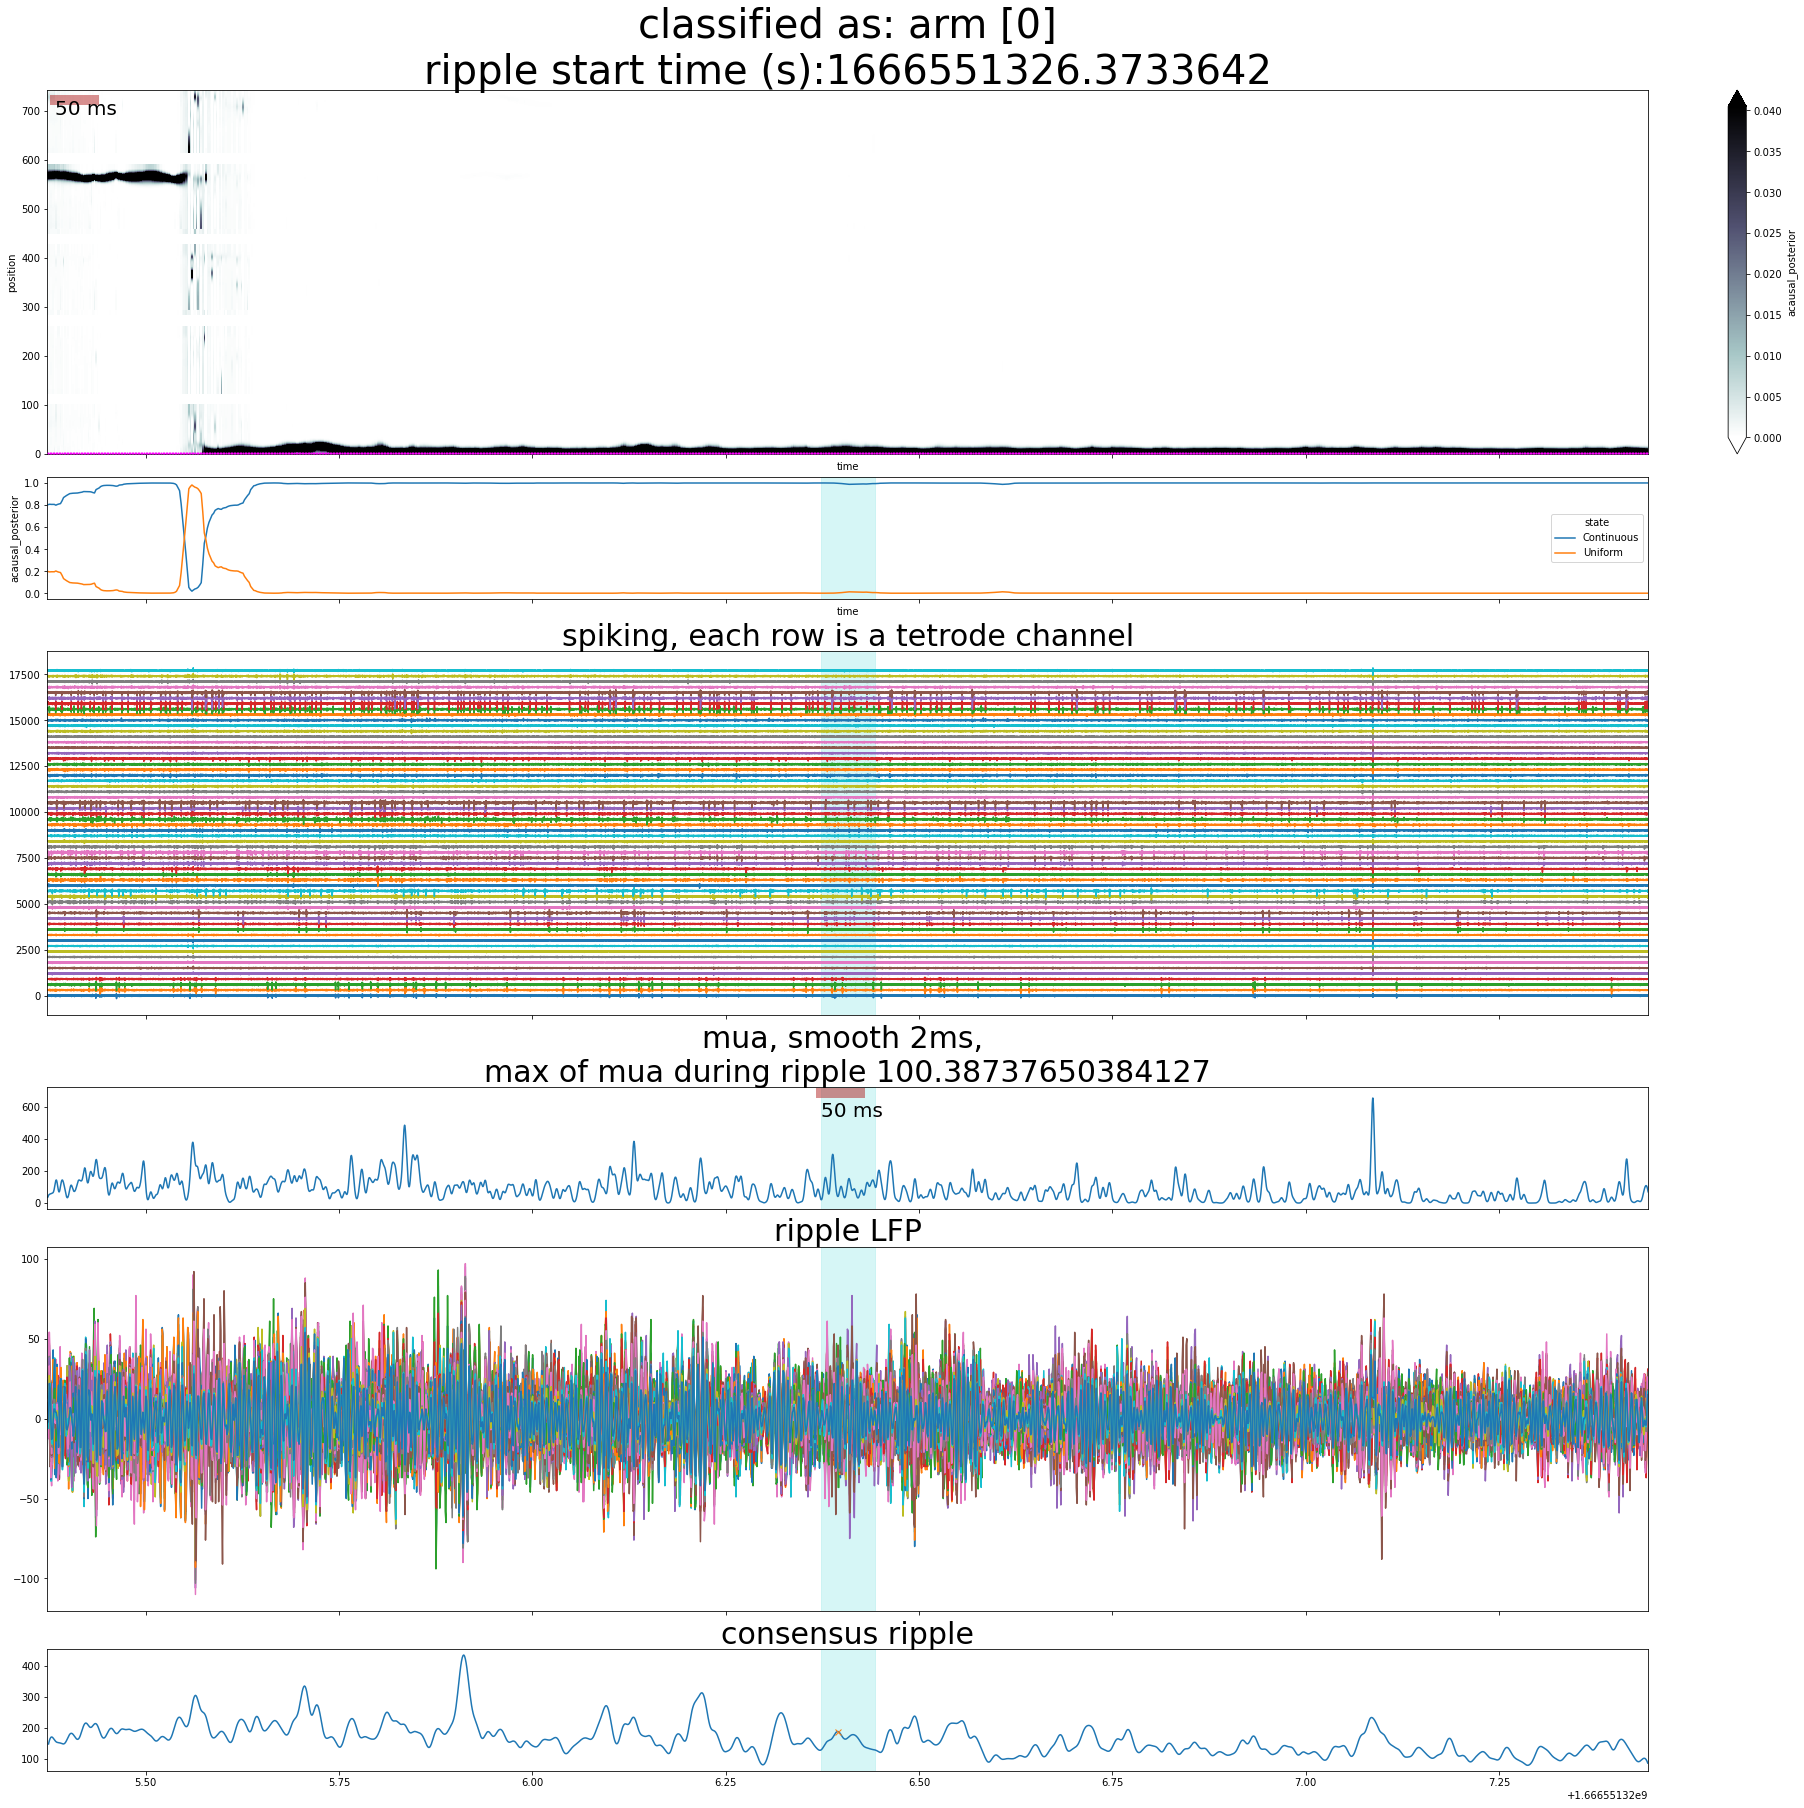

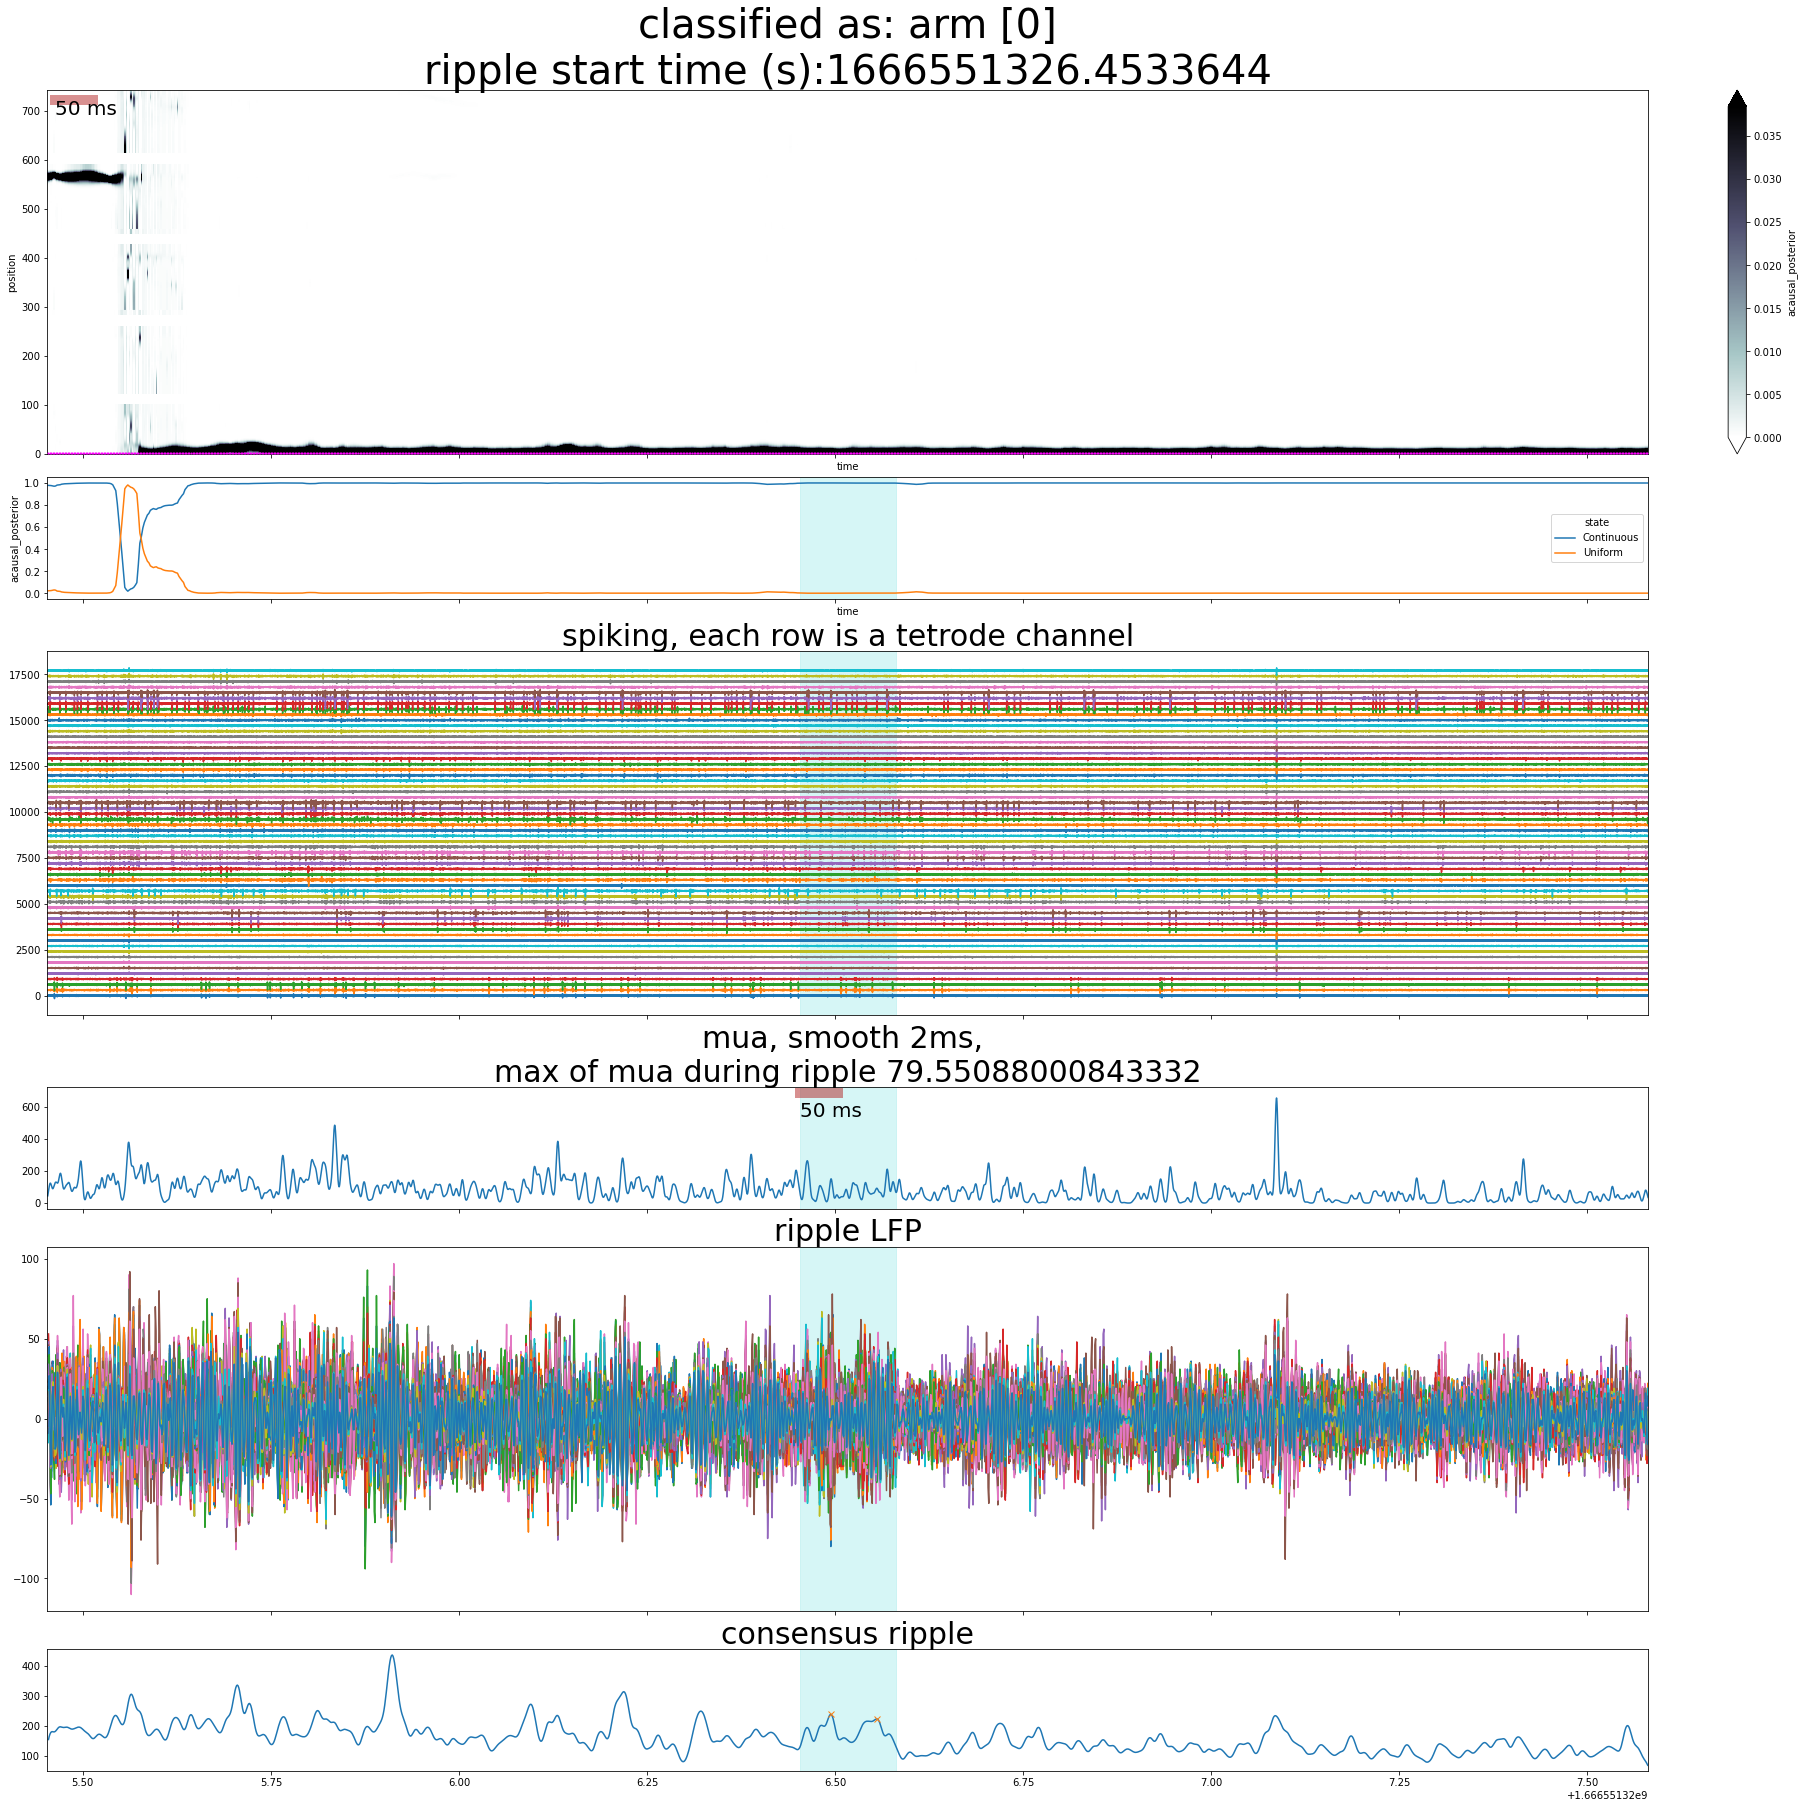

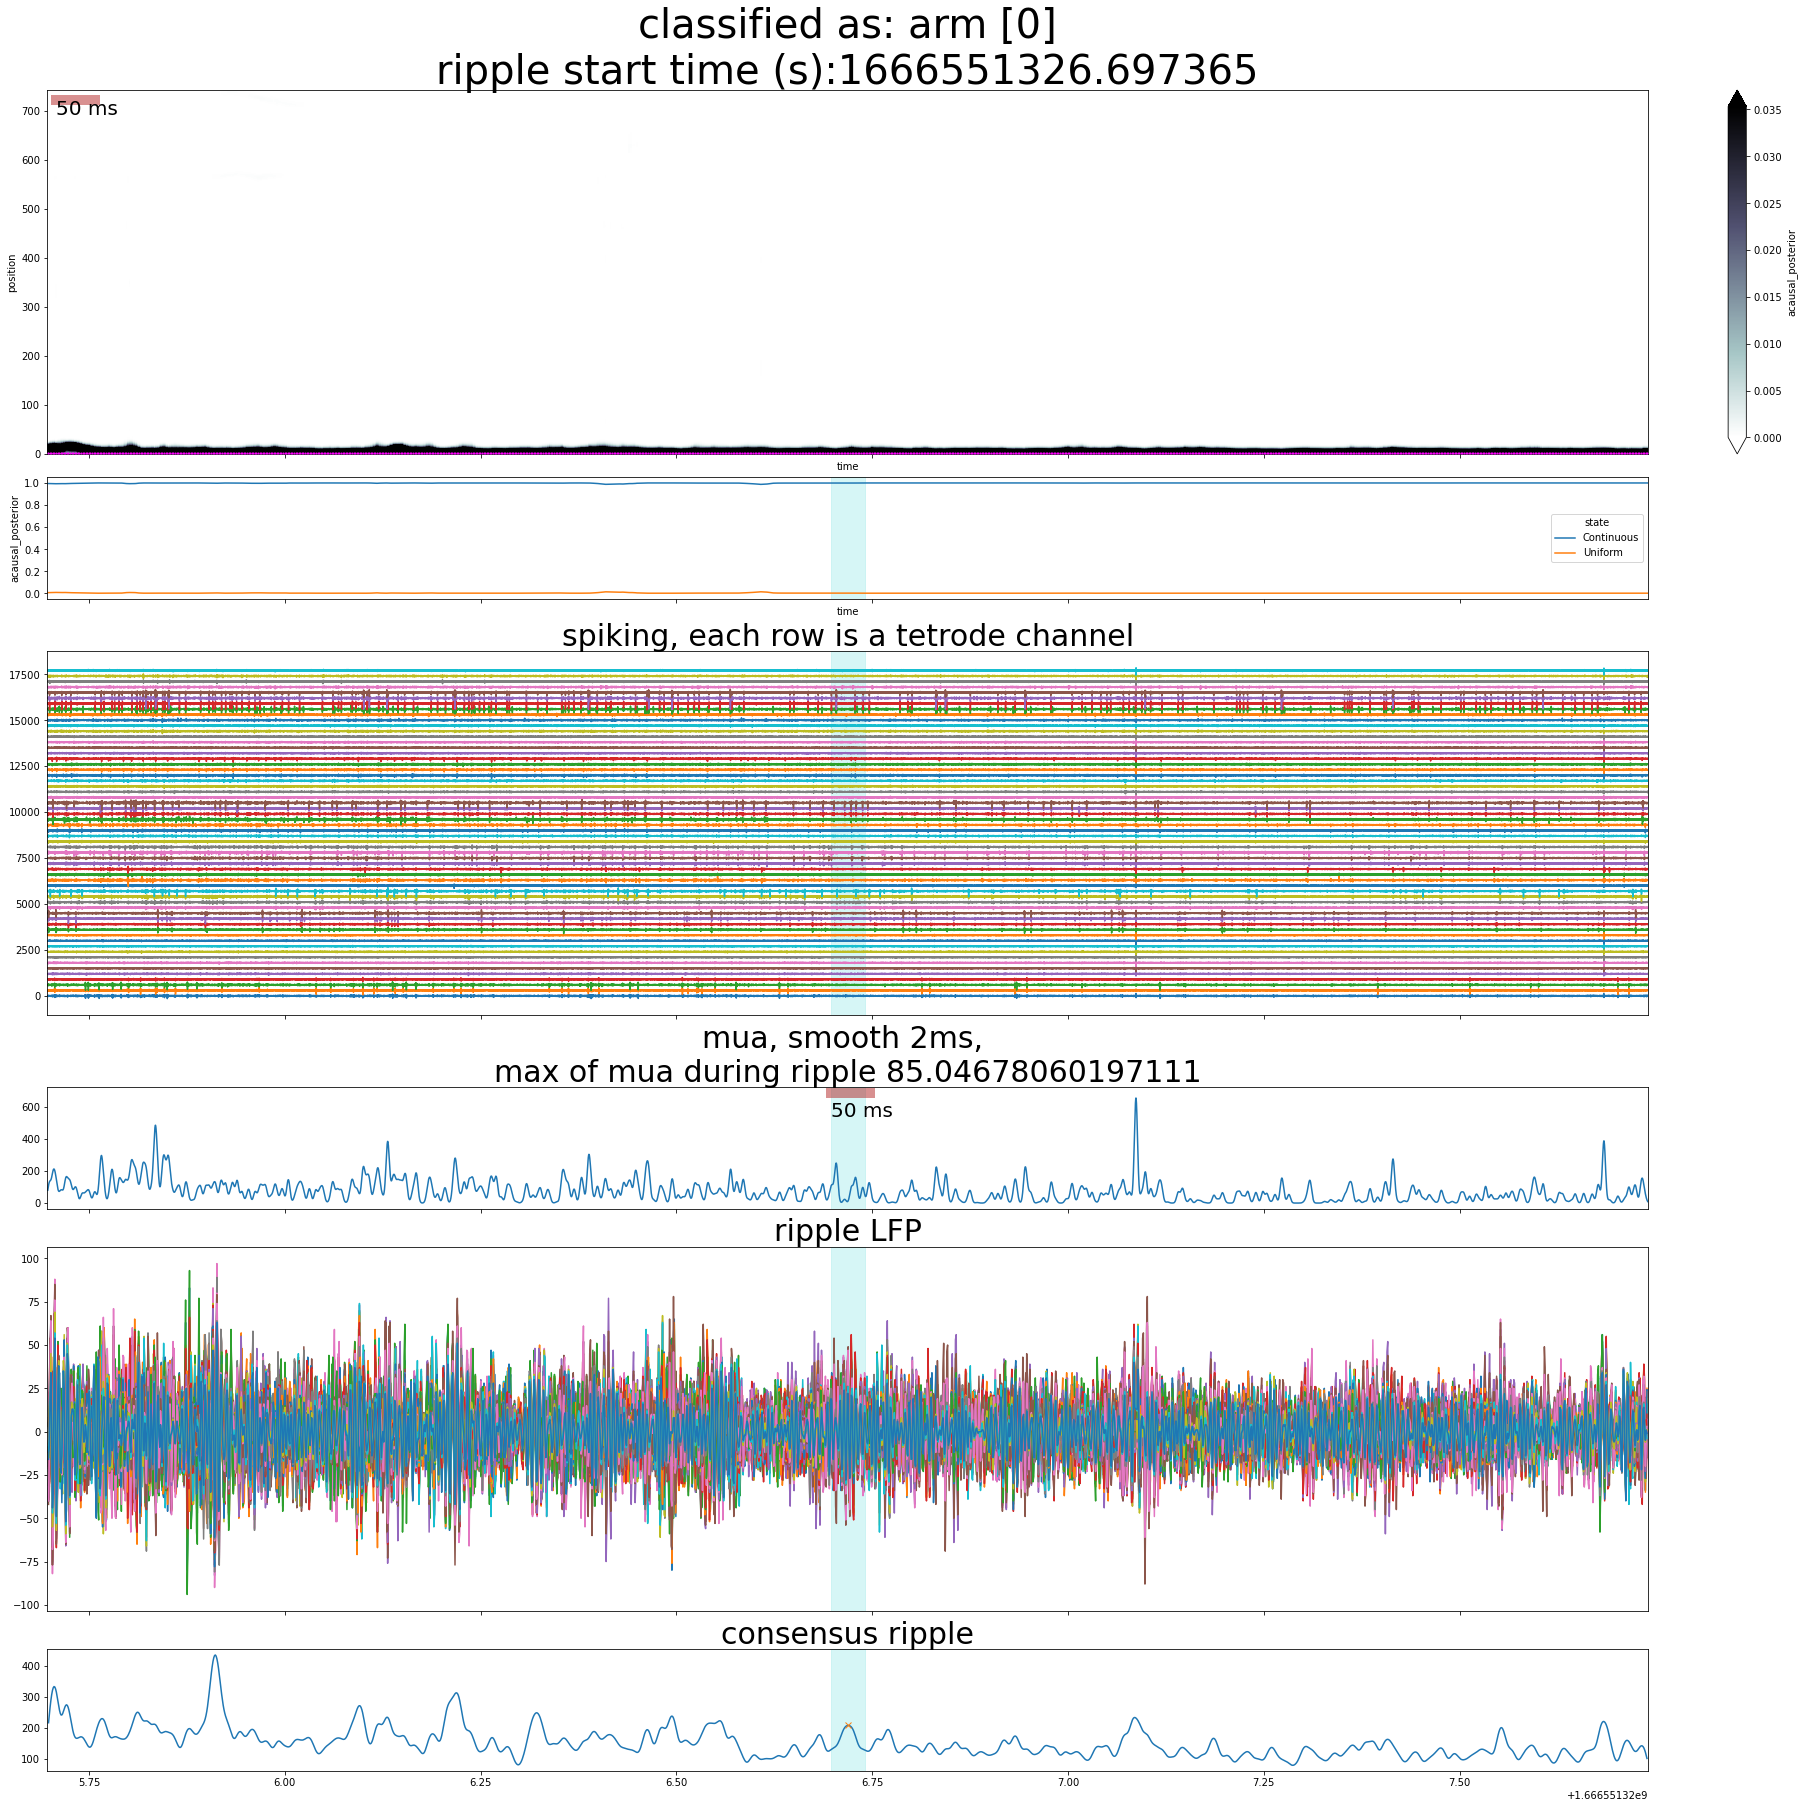

In [23]:
stored_output.show()

In [22]:
print('here')

here


In [ ]:
add_replay(8)

epoch name 08_Seq2Session4


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/molly20220419_M0XWSHVQ5H.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/molly20220419_12BQZSDIB3.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"),

trial 1
trial failed: 1
position_subset               linear_position  track_segment_id  projected_x_position  \
time                                                                    
1.650400e+09              NaN                 0                   NaN   
1.650400e+09              NaN                 0                   NaN   
1.650400e+09              NaN                 0                   NaN   
1.650400e+09              NaN                 0                   NaN   
1.650400e+09              NaN                 0                   NaN   
...                       ...               ...                   ...   
1.650400e+09       743.032159                 9                 310.5   
1.650400e+09       743.032159                 9                 310.5   
1.650400e+09       743.032159                 9                 310.5   
1.650400e+09       743.032159                 9                 310.5   
1.650400e+09       743.032159                 9                 310.5   

          

/home/shijiegu/Documents/spyglass/src/spyglass/shijiegu/Analysis_SGU.py:430: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(5, 1, figsize=(25, 25), sharex=True,


trial 4
41.310410169410275
trial 5
41.310410169410275
trial 6
41.310410169410275
trial 7
41.310410169410275
trial 8
41.310410169410275
trial 9
41.310410169410275


In [ ]:
%%capture stored_output
add_replay(2)
add_replay(4)
add_replay(6)
add_replay(8)
add_replay(10)

In [208]:
add_replay(10)
add_replay(12)

epoch name 10_Seq2Session5
trial 1
trial failed: 1
position_subset               linear_position  track_segment_id  projected_x_position  \
time                                                                    
1.650492e+09              NaN                 0                   NaN   
1.650492e+09              NaN                 0                   NaN   
1.650492e+09              NaN                 0                   NaN   
1.650492e+09              NaN                 0                   NaN   
1.650492e+09              NaN                 0                   NaN   
...                       ...               ...                   ...   
1.650492e+09       583.187638                 8                257.75   
1.650492e+09       583.187638                 8                257.75   
1.650492e+09       583.187638                 8                257.75   
1.650492e+09       583.187638                 8                257.75   
1.650492e+09       583.187638                 8          

In [144]:
    epoch_num=8
    
    # 1. Load state script
    key={'nwb_file_name':nwb_copy_file_name,'epoch':epoch_num}
    log=(TrialChoice & key).fetch1('choice_reward')
    epoch_name=(TrialChoice & key).fetch1('epoch_name')
    epoch_pos_name='pos '+str(int(epoch_name[:2])-1)+' valid times'
    print('epoch name',epoch_name)
    log_df=pd.DataFrame(log)

epoch name 08_Seq2Session3


In [145]:
log_df.loc[66,:]

timestamp_H       1.650062e+09
Home              1.000000e+00
timestamp_O       1.650062e+09
OuterWellIndex    2.000000e+00
rewardNum         1.000000e+00
Name: 66, dtype: float64

In [148]:
log_df.loc[66,:].timestamp_H

1650062026.5339143

In [149]:
linear_position_df = (IntervalLinearizedPosition() &
                      {'nwb_file_name': nwb_copy_file_name,
                       'interval_list_name': epoch_pos_name,
                       'position_info_param_name': 'default_decoding'}
                         ).fetch1_dataframe()

In [160]:
    t=68
    
    # for each trial, find important times
    t_home=log_df.loc[t,'timestamp_H']
    t_outer=log_df.loc[t,'timestamp_O']
    if t+1<len(log_df):
        t_end=log_df.loc[t+1,'timestamp_H']
    else:
        t_end=log_df.loc[t,'timestamp_H']+10
    
    ''' HOME '''
    # find times close to home well
    time_slice = slice(t_home,t_outer)
    current_location = node_location['home']
    position_subset=linear_position_df.loc[time_slice]
    close_ind=np.argwhere(np.abs(position_subset.linear_position.values-
                                 current_location)<5).ravel()

In [161]:
position_subset.index[0]

1650062082.9242132

In [162]:
position_subset

linear_position  track_segment_id  projected_x_position  \
time                                                                    
1.650062e+09       238.028962                 6            138.679149   
1.650062e+09       238.028769                 6            138.679305   
1.650062e+09       238.028577                 6            138.679462   
1.650062e+09       238.028385                 6            138.679619   
1.650062e+09       238.028193                 6            138.679776   
...                       ...               ...                   ...   
1.650062e+09       236.523876                 6            139.907675   
1.650062e+09       236.523684                 6            139.907832   
1.650062e+09       236.523492                 6            139.907989   
1.650062e+09       236.523300                 6            139.908145   
1.650062e+09       236.523108                 6            139.908302   

              projected_y_position  
time                                
1.650062e+09            104.692813  
1.650062e+09            104.692924  
1.650062e+09            104.693035  
1.650062e+09            104.693146  
1.650062e+09            104.693257  
...                            ...  
1.650062e+09            105.562298  
1.650062e+09            105.562409  
1.650062e+09            105.562520  
1.650062e+09            105.562631  
1.650062e+09            105.562742  

[7839 rows x 4 columns]

In [124]:
    epoch_num=6
    
    # 1. Load state script
    key={'nwb_file_name':nwb_copy_file_name,'epoch':epoch_num}
    log=(TrialChoice & key).fetch1('choice_reward')
    epoch_name=(TrialChoice & key).fetch1('epoch_name')
    epoch_pos_name='pos '+str(int(epoch_name[:2])-1)+' valid times'
    print('epoch name',epoch_name)
    log_df=pd.DataFrame(log)

    # 1.5 Pre-make result directory:
    decoding_path=(Decode() & {'nwb_file_name':nwb_copy_file_name}).fetch('posterior')[0]
    exampledir=os.path.join(os.path.split(decoding_path)[0],nwb_file_name,epoch_name)
    isExist = os.path.exists(exampledir)
    if not isExist:
        os.makedirs(exampledir)

    # 2. Pre-expand result: Augment choice_reward table to be choice_reward_replay
    log_df_replay=log_df.copy()
    log_df_replay.insert(5,'ripple_H',[[] for i in range(len(log_df))]) #hold ripple times
    log_df_replay.insert(6,'ripple_O',[[] for i in range(len(log_df))])
    log_df_replay.insert(7,'replay_H',[[] for i in range(len(log_df))]) #hold decoded replay
    log_df_replay.insert(8,'ripple_peak_H',[[] for i in range(len(log_df))]) #hold decoded replay
    log_df_replay.insert(9,'replay_O',[[] for i in range(len(log_df))])
    log_df_replay.insert(10,'ripple_peak_O',[[] for i in range(len(log_df))]) #hold decoded replay

    # 3. linear map
    linear_map,node_location=get_linearization_map()

    # 4. load position, decoding, ripple times, mua threshold
    (linear_position_df,decode,ripple_nwb,
     ripple_timestamps,ripple_times,
     recordings,neural_ts,
     mua,mua_time)=load_everything(nwb_copy_file_name,
                    epoch_name,
                    epoch_pos_name)
    


epoch name 06_Seq2Session2


In [78]:
(IntervalList & {'nwb_file_name': nwb_copy_file_name,'interval_list_name': epoch_pos_name}).fetch1('valid_times')[0]

array([1.65030769e+09, 1.65030907e+09])

In [43]:
    position_info = (IntervalPositionInfo() & {'nwb_file_name': nwb_copy_file_name,
                     'interval_list_name': epoch_pos_name,
                     'position_info_param_name': 'default'}).fetch1_dataframe()

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/molly20220418_HJ00MG2JQ9.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)


In [53]:
log_df.loc[60].timestamp_H

1650309043.9077516

In [61]:
log_df.loc[61].timestamp_H

1650309062.4968216

In [73]:
log_df.loc[82].timestamp_H

1650309696.696209

In [81]:
ripple_timestamps[0]

1650307630.6322308

In [80]:
position_info.index[0]

1650307689.4366117

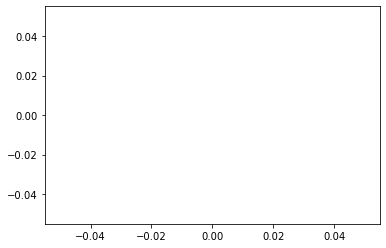

In [58]:
plt.plot(linear_position_df.loc[linear_position_df.index>1650309121,'linear_position'])

In [40]:
add_replay(10)

epoch name 10_Seq2Session5


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/molly20220418_DGFB07I19D.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/molly20220418_1XEB8DQJ3N.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"),

trial 1
59.76105610818382
trial 4
59.76105610818382
trial 5
59.76105610818382
trial 6
59.76105610818382
trial 7
59.76105610818382
trial 8
59.76105610818382
trial 9
59.76105610818382
trial 10
59.76105610818382
trial 11
59.76105610818382
trial 12
59.76105610818382
trial 13
59.76105610818382
trial 14
59.76105610818382
trial 15
59.76105610818382
trial 16
59.76105610818382
trial 17
59.76105610818382
trial 18
59.76105610818382
trial 19
59.76105610818382
trial 20
59.76105610818382
trial 21
59.76105610818382
trial 22
59.76105610818382
trial 23
59.76105610818382
trial 24
59.76105610818382
trial 25
59.76105610818382
trial 26
59.76105610818382
trial 27
59.76105610818382
trial 28
59.76105610818382
trial 29
59.76105610818382
trial 30
59.76105610818382
trial 31
59.76105610818382
trial 32
59.76105610818382
trial 33
59.76105610818382
trial 34
59.76105610818382
trial 35
59.76105610818382
trial 36
59.76105610818382
trial 37
59.76105610818382
trial 38
59.76105610818382
trial 39
59.76105610818382
trial 40

In [9]:
TrialChoiceReplay() & {'nwb_file_name':nwb_copy_file_name}

*nwb_file_name *epoch    epoch_name     choice_rew
+------------+ +-------+ +------------+ +--------+
eliot20221021_ 2         02_Seq2Session =BLOB=    
eliot20221021_ 4         04_Seq2Session =BLOB=    
eliot20221021_ 6         06_Seq2Session =BLOB=    
eliot20221021_ 8         08_Seq2Session =BLOB=    
 (Total: 4)

In [12]:
choice_reward_replay=(TrialChoiceReplay() & {'nwb_file_name':nwb_copy_file_name,
                                            'epoch':2}).fetch1('choice_reward_replay')

In [13]:
pd.DataFrame(choice_reward_replay)

timestamp_H  Home   timestamp_O  OuterWellIndex  rewardNum  \
1   1.666029e+09   1.0  1.666029e+09             2.0        1.0   
2   1.666029e+09   1.0  1.666029e+09             4.0        1.0   
3   1.666029e+09   1.0  1.666029e+09             1.0        1.0   
4   1.666029e+09   1.0  1.666029e+09             3.0        2.0   
5   1.666029e+09   1.0  1.666029e+09             2.0        1.0   
..           ...   ...           ...             ...        ...   
76  1.666030e+09   1.0  1.666030e+09             2.0        1.0   
77  1.666030e+09   1.0  1.666030e+09             4.0        2.0   
78  1.666031e+09   1.0  1.666031e+09             3.0        1.0   
79  1.666031e+09   1.0  1.666031e+09             1.0        1.0   
80  1.666031e+09   1.0  1.666031e+09             3.0        1.0   

                                             ripple_H  \
1   [[[1666028711.3898711, 1666028711.4418712]], [...   
2   [[[1666028741.6998477, 1666028741.8738475]], [...   
3   [[[1666028778.3398192, 1666028778.3798192]], [...   
4   [[[1666028813.5817916, 1666028813.6257918]], [...   
5   [[[1666028860.9817548, 1666028861.0737548]], [...   
..                                                ...   
76  [[[1666030472.856501, 1666030472.9725008]], [[...   
77       [[[1666030487.5344896, 1666030487.7504895]]]   
78       [[[1666030508.4864733, 1666030508.6104732]]]   
79  [[[1666030527.3924587, 1666030527.4524586], [1...   
80        [[[1666030547.484443, 1666030547.5284429]]]   

                                             ripple_O  \
1   [[[1666028729.8738568, 1666028729.9538567]], [...   
2   [[[1666028761.595832, 1666028761.6998322]], [[...   
3   [[[1666028801.9758008, 1666028802.1278007]], [...   
4   [[[1666028835.5557747, 1666028835.6037745], [1...   
5   [[[1666028872.213746, 1666028872.283746]], [[1...   
..                                                ...   
76  [[[1666030482.1644938, 1666030482.2204938]], [...   
77  [[[1666030495.5644834, 1666030495.7044833]], [...   
78                                                 []   
79       [[[1666030540.0284488, 1666030540.0704486]]]   
80  [[[1666030557.3424354, 1666030557.4044352]], [...   

                                             replay_H ripple_peak_H  \
1     [[0], [0], [0], [0], [0], [0], [0], [2.0, nan]]            []   
2   [[0], [0], [0], [0], [0], [0], [0], [0], [0, 0...            []   
3   [[0], [0], [0], [0], [0.0, nan, 0.0], [0], [0]...            []   
4   [[0], [0.0, 5.0, 0.0, nan], [0], [0], [0.0, na...            []   
5   [[0], [0], [0, 2, 0], [0.0, 5.0, nan, 0.0], [0...            []   
..                                                ...           ...   
76                        [[0], [0], [0], [0.0, nan]]            []   
77                                              [[0]]            []   
78                                              [[0]]            []   
79                      [[0.0, nan], [1.0, nan], [5]]            []   
80                                              [[0]]            []   

                                         replay_O ripple_peak_O  current  \
1                  [[2], [2], [2], [5], [2], [2]]            []      2.0   
2   [[4], [4], [4], [4], [4], [4], [4], [2], [2]]            []      4.0   
3                       [[1], [1], [1], [1], [1]]            []      1.0   
4         [[2.0, nan], [3], [2], [3.0, nan, 3.0]]            []      3.0   
5        [[2], [2], [2], [2], [2], [1], [2], [2]]            []      2.0   
..                                            ...           ...      ...   
76                                [[2], [2], [2]]            []      2.0   
77               [[4], [3.0, nan, 1.0], [4], [4]]            []      4.0   
78                                             []            []      3.0   
79                                          [[1]]            []      1.0   
80                                [[3], [3], [3]]            []      3.0   

    future_H  future_O  past  past_reward  
1        2.0       4

### one trial

102.22737903670286
[0.9740309715270996, 0.0041763996705412865, 0.0050851935520768166, 0.003176255151629448, 0.003962892107665539, 0.009568370878696442]
mean of mua during ripple 361.3453948373179
[0.00013235252117738128, 0.00016257786774076521, 0.9989458322525024, 0.0001882933865999803, 0.00017953822680283338, 0.0003914232220267877]
[0.0037647956050932407, 0.004990492016077042, 0.9715962409973145, 0.004646184388548136, 0.00467778230085969, 0.010324392933398485]
mean of mua during ripple 143.00882579087727
mean of mua during ripple 148.29820449309983


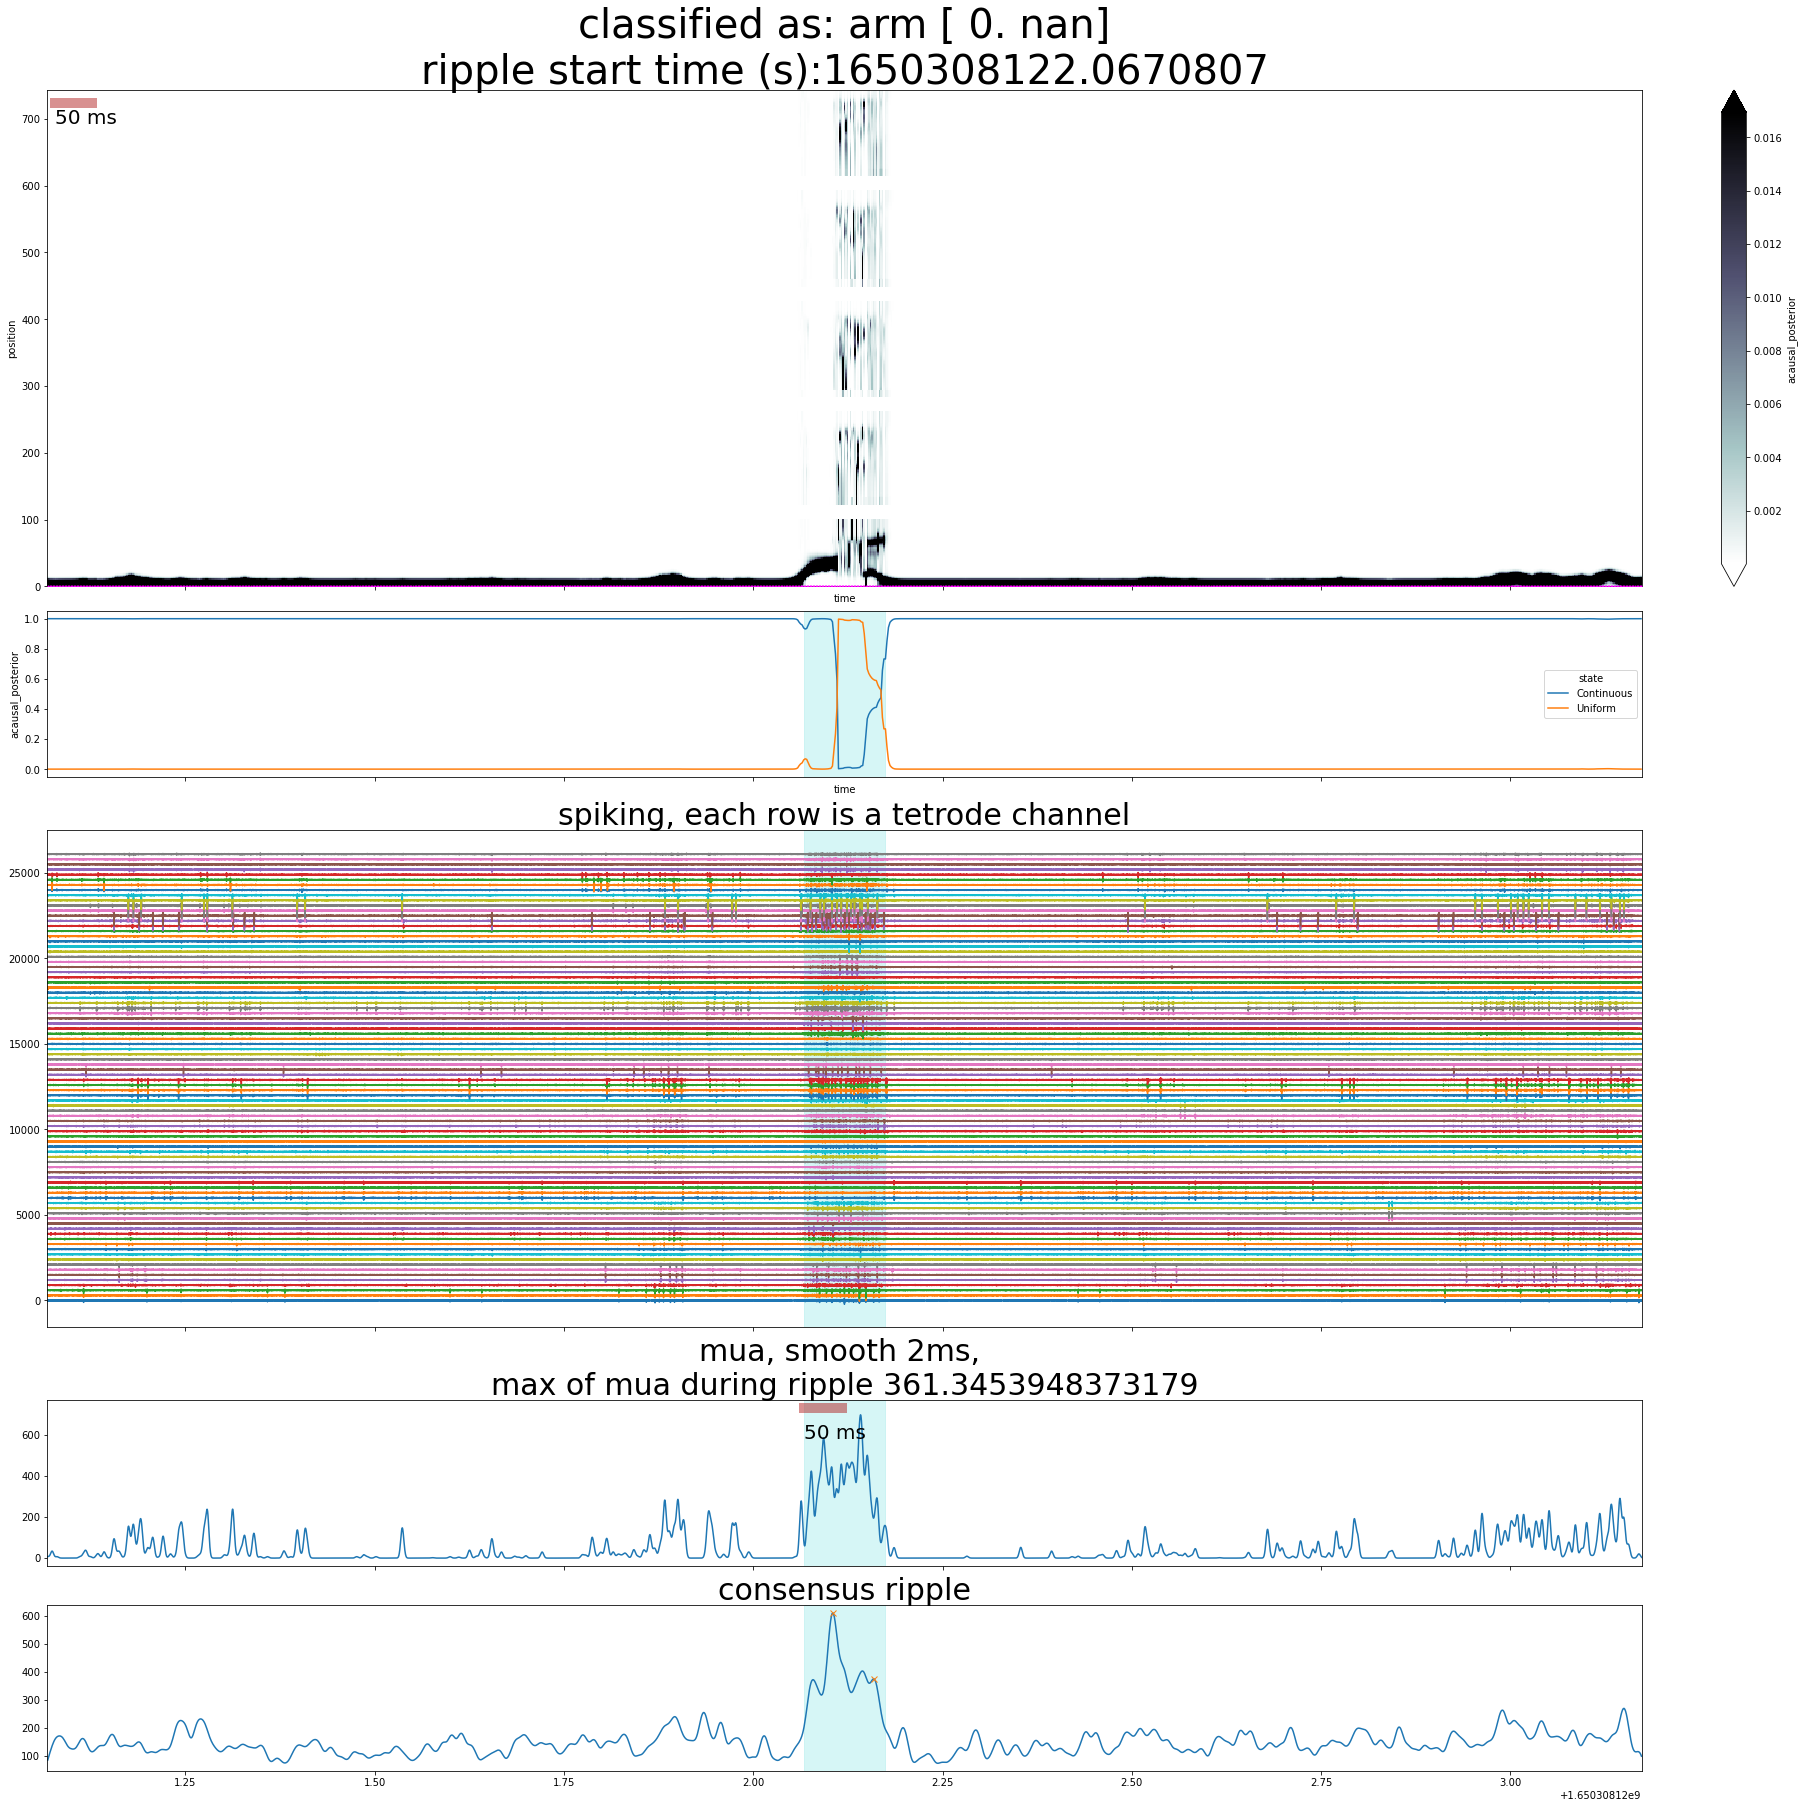

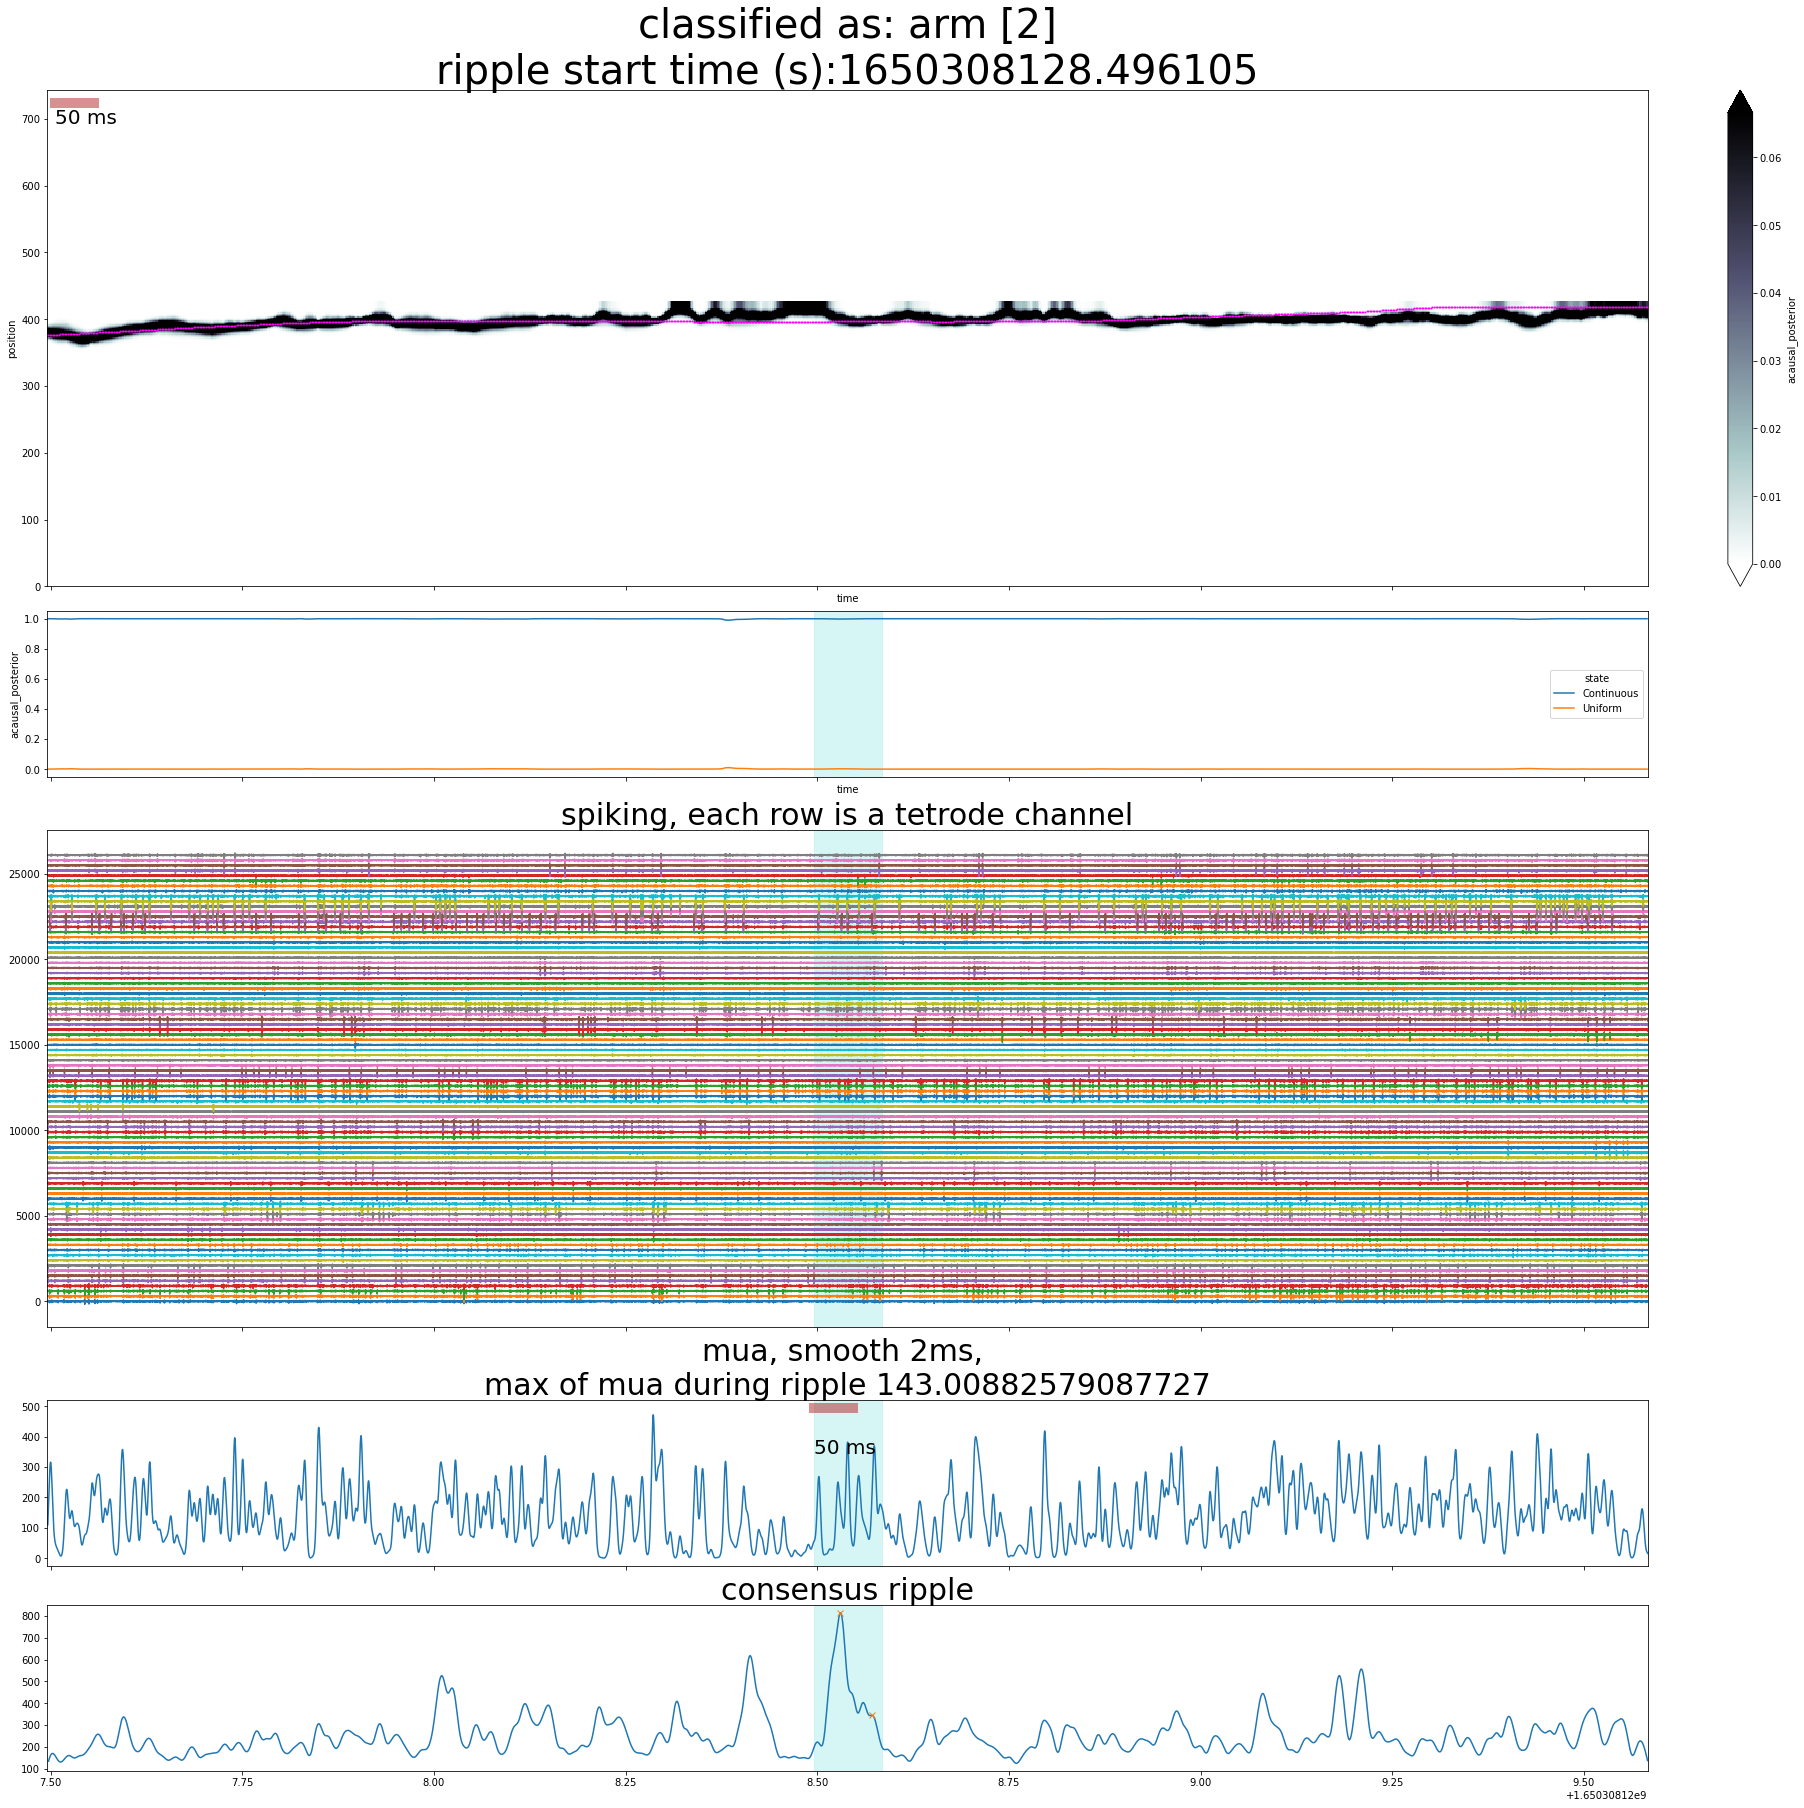

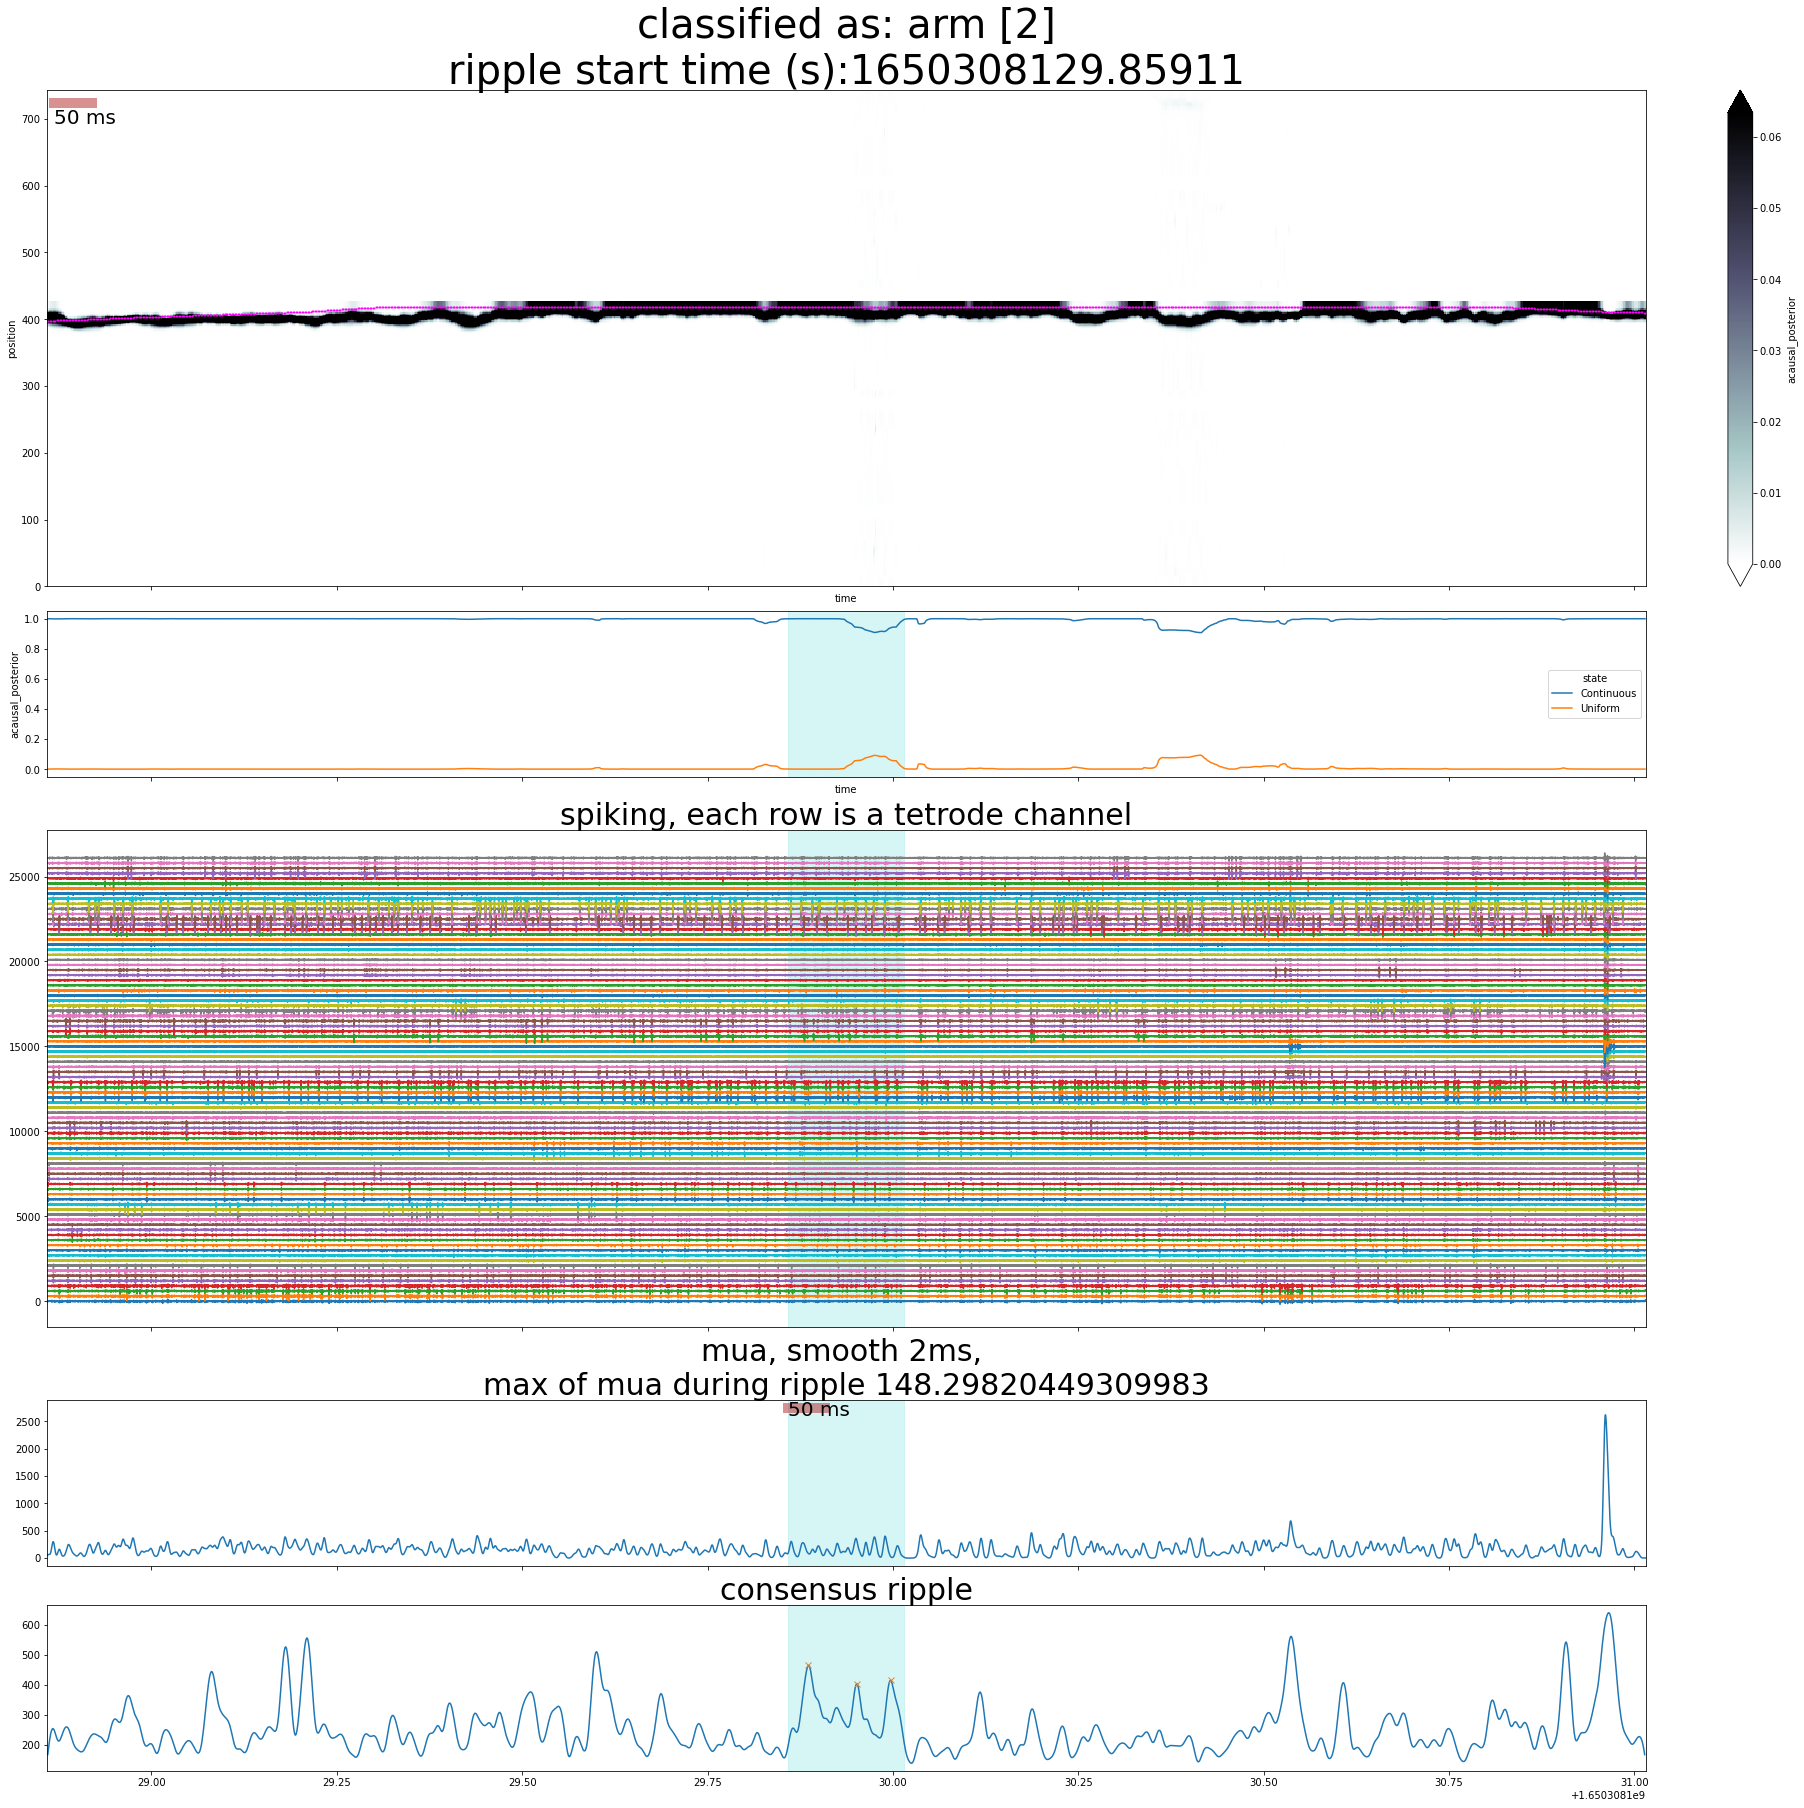

In [115]:
# uncomment the last section in the above cell
ripple_H,replay_H,peak_H,ripple_O,replay_O,peak_O=find_ripple_classify_decode(20)

In [30]:
mua_threshold=np.mean(mua)
mua_threshold

103.14446443798306

### all trials

In [103]:
numWorker=30
print('num of worker:',numWorker)
with multiprocessing.Pool(numWorker) as p:
    results=p.map(find_ripple_classify_decode,legal_trials)

num of worker: 30
103.14446443798306
103.14446443798306103.14446443798306103.14446443798306103.14446443798306103.14446443798306

103.14446443798306
103.14446443798306

103.14446443798306103.14446443798306

103.14446443798306

103.14446443798306103.14446443798306103.14446443798306103.14446443798306103.14446443798306103.14446443798306103.14446443798306
103.14446443798306

103.14446443798306


103.14446443798306103.14446443798306
103.14446443798306





103.14446443798306103.14446443798306103.14446443798306103.14446443798306
103.14446443798306103.14446443798306103.14446443798306


103.14446443798306



[0.9963321089744568, 0.0005938186659477651, 0.0006076196441426873, 0.0005965312011539936, 0.0006348529714159667, 0.001235119765624404]
[0.9772823452949524, 0.003486721543595195, 0.003269072389230132, 0.0042370883747935295, 0.0037787395995110273, 0.007946096127852798]
[0.0002934010117314756, 0.00044258125126361847, 0.0005727284005843103, 0.00048617852735333145, 0.9968107342720032, 0.00139444

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fcecc98d9a0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fccc7cbf760>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/connection.py:341: UserWarning: MySQL server has gone away. Reconnecting to the server.
  warnings.warn("MySQL server has gone away. Reconnecting to the server.")
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fcecc98d9a0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fccc7cbf760>
  self.pid = os.fork()
/home/shijiegu/anaconda3

In [76]:
len(results)

77

In [81]:
for i in range(len(legal_trials)):
    t=legal_trials[i]
    # add to the choice_reward_replay
    log_df_replay.at[t, 'ripple_H']=results[i][0]
    log_df_replay.at[t, 'ripple_O']=results[i][3]
    
    log_df_replay.at[t, 'replay_H']= results[i][1]
    log_df_replay.at[t, 'replay_O']= results[i][4]
    
    log_df_replay.at[t, 'ripple_peak_H']= results[i][2]
    log_df_replay.at[t, 'ripple_peak_O']= results[i][5]
log_df_replay_subset=log_df_replay.loc[legal_trials,:].copy()

In [82]:
pd.set_option("display.max_rows", None)

In [83]:
log_df_replay

timestamp_H  Home   timestamp_O  OuterWellIndex  rewardNum  \
1   1.650477e+09   1.0  1.650478e+09             3.0        2.0   
2   1.650478e+09   1.0  1.650478e+09             4.0        2.0   
3   1.650478e+09   1.0  1.650478e+09             2.0        2.0   
4            NaN   NaN  1.650478e+09             1.0        0.0   
5   1.650478e+09   1.0  1.650478e+09             3.0        1.0   
6   1.650478e+09   1.0  1.650478e+09             4.0        1.0   
7   1.650478e+09   1.0  1.650478e+09             2.0        1.0   
8   1.650478e+09   1.0  1.650478e+09             1.0        2.0   
9   1.650478e+09   1.0  1.650478e+09             4.0        1.0   
10  1.650478e+09   1.0  1.650478e+09             3.0        2.0   
11  1.650478e+09   1.0  1.650478e+09             4.0        2.0   
12  1.650478e+09   1.0  1.650478e+09             2.0        2.0   
13           NaN   NaN  1.650478e+09             1.0        0.0   
14  1.650478e+09   1.0  1.650478e+09             3.0        1.0   
15  1.650478e+09   1.0  1.650478e+09             4.0        1.0   
16  1.650478e+09   1.0  1.650478e+09             1.0        2.0   
17  1.650478e+09   1.0  1.650478e+09             3.0        2.0   
18  1.650478e+09   1.0  1.650478e+09             4.0        2.0   
19  1.650478e+09   1.0  1.650478e+09             2.0        2.0   
20  1.650478e+09   1.0  1.650478e+09             1.0        2.0   
21  1.650478e+09   1.0  1.650478e+09             3.0        2.0   
22  1.650478e+09   1.0  1.650478e+09             4.0        2.0   
23  1.650478e+09   1.0  1.650478e+09             2.0        2.0   
24  1.650478e+09   1.0  1.650478e+09             1.0        2.0   
25  1.650478e+09   1.0  1.650478e+09             3.0        2.0   
26  1.650478e+09   1.0  1.650478e+09             4.0        2.0   
27  1.650478e+09   1.0  1.650478e+09             2.0        2.0   
28  1.650478e+09   1.0  1.650478e+09             1.0        2.0   
29  1.650478e+09   1.0  1.650478e+09             4.0        1.0   
30  1.650478e+09   1.0  1.650478e+09             1.0        1.0   
31  1.650478e+09   1.0  1.650478e+09             2.0        1.0   
32  1.650478e+09   1.0  1.650478e+09             3.0        2.0   
33  1.650478e+09   1.0  1.650478e+09             4.0        2.0   
34  1.650478e+09   1.0  1.650478e+09             2.0        2.0   
35  1.650478e+09   1.0  1.650478e+09             1.0        2.0   
36  1.650478e+09   1.0  1.650478e+09             3.0        2.0   
37  1.650478e+09   1.0  1.650478e+09             4.0        2.0   
38  1.650478e+09   1.0  1.650478e+09             2.0        2.0   
39  1.650478e+09   1.0  1.650478e+09             1.0        2.0   
40  1.650478e+09   1.0  1.650478e+09             3.0        2.0   
41  1.650478e+09   1.0  1.650478e+09             4.0        2.0   
42  1.650478e+09   1.0  1.650478e+09             2.0        2.0   
43  1.650478e+09   1.0  1.650478e+09             1.0        2.0   
44  1.650479e+09   1.0  1.650479e+09             3.0        2.0   
45  1.650479e+09   1.0  1.650479e+09             4.0        2.0   
46  1.650479e+09   1.0  1.650479e+09             2.0        2.0   
47  1.650479e+09   1.0  1.650479e+09             1.0        2.0   
48  1.650479e+09   1.0  1.650479e+09             3.0        2.0   
49  1.650479e+09   1.0  1.650479e+09             4.0        2.0   
50  1.650479e+09   1.0  1.650479e+09             2.0        2.0   
51  1.650479e+09   1.0  1.650479e+09             1.0        2.0   
52  1.650479e+09   1.0  1.650479e+09             3.0        2.0   
53  1.650479e+09   1.0  1.650479e+09             4.0        2.0   
54  1.650479e+09   1.0  1.650479e+09             2.0        2.0   
55  1.650479e+09   1.0  1.650479e+09             1.0        2.0   
56  1.650479e+09   1.0  1.650479e+09             3.0        2.0   
57  1.650479e+09   1.0  1.650479e+09             4.0        2.0   
58  1.650479e+09   1.0  1.650479e+09             2.0        2.0   
59  1.650479e+09   1.0  1.650479e+09             3.0

In [106]:
# insert into Spyglass
key={'nwb_file_name':nwb_copy_file_name,'epoch':epoch_num,'choice_reward_replay':log_df_replay_subset.to_dict()}
TrialChoiceReplay().make(key,replace=True)

In [14]:
TrialChoiceReplay()

*nwb_file_name *epoch    epoch_name     choice_rew
+------------+ +-------+ +------------+ +--------+
molly20220418_ 6         06_Seq2Session =BLOB=    
molly20220420_ 4         04_Seq2Session =BLOB=    
 (Total: 2)

## investigate short ripples

In [99]:
short_ripple_H=[]
for i in range(len(legal_trials)):
    t=trial_ind[i]
    ripple_H=log_df_replay.loc[t, 'ripple_H']
    for ri in range(len(ripple_H)):
        if len(ripple_H[ri])==0: #state time is short
            continue
        ripple_=np.reshape(ripple_H[ri],(1,-1))
        if (ripple_[0,-1]-ripple_[0,0])<=0.05:
            short_ripple_H.append((t,ri+1))

In [43]:
replay_ripple_count=np.zeros((10,5))
replay_ripple=np.zeros((10,5),dtype=np.object)
for i in range(len(trial_ind)):
    t=trial_ind[i]
    replay_all=log_df_replay.loc[t,'replay_O']
    ripple_all=log_df_replay.loc[t,'ripple_peak_O']
    
    for ri in range(len(replay_all)):
        replay=replay_all[ri]
        unique_arms=np.unique(np.setdiff1d(replay,[5]))
        replay_arm_num=len(unique_arms)
    
        ripple_num=len(ripple_all[ri])
        if ripple_num<=10 and replay_arm_num<=5:
            replay_ripple_count[ripple_num-1,replay_arm_num-1]+=1
            if type(replay_ripple[ripple_num-1,replay_arm_num-1])=='list':
                replay_ripple[ripple_num-1,replay_arm_num-1].append(replay)
            else:
                replay_ripple[ripple_num-1,replay_arm_num-1]=replay

/tmp/ipykernel_1448730/1564541742.py:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  replay_ripple=np.zeros((10,5),dtype=np.object)


In [44]:
replay_ripple[:,2]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=object)

[Text(0, 2, '3'), Text(0, 3, '2'), Text(0, 4, '1')]

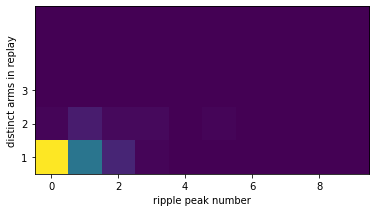

In [45]:
fig, axes = plt.subplots(nrows=1)
plt.imshow(np.flipud(replay_ripple_count.T))
axes.set_xlabel('ripple peak number')
axes.set_ylabel('distinct arms in replay')
axes.set_yticks([2,3,4])
axes.set_yticklabels(['3','2','1'])